# Group Recommender System

This file contains an aggregation algorithm for groups of users, aswell as its evaluation, explanations and evaluations of explanations.  

In [26]:
# Imports 
import pandas as pd
import numpy as np
import random
import itertools
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from lenskit import topn
from lenskit import crossfold as xf
from lenskit import batch, topn, util
from lenskit.algorithms import Recommender, user_knn as uknn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.model_selection import train_test_split
warnings.filterwarnings(action='ignore', category=RuntimeWarning, module='lenskit.metrics.topn')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='lenskit.metrics.topn')
from surprise.model_selection import cross_validate
from lenskit.algorithms import Recommender, bias, basic, item_knn
from lenskit.algorithms.user_knn import UserUser 

First we load the dataset and preprocess the data. More specifications about this can be found in the "data_preprocessing.ipynb" file. 

In [27]:
def load_dataset():
    preprocessed_dataset_folder = "../Data/PreprocessedDataset"
    ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")
    movies_df = pd.read_csv(preprocessed_dataset_folder+"/movies.csv")
    user_plots_ratings_df = pd.read_csv(preprocessed_dataset_folder+"/user_plots.csv") #first run notebook algorithm_experiments to get this data
    return ratings_df, movies_df, user_plots_ratings_df

## Synthetic group generation

Opposed to using user-user similarity metric (e.g PCC) to create groups, we have decided to try something new (K-Means clustering algorithm).

1. The initial goal is to segment the data into 4 distinct groups based on user features in the user matrix, this is the ratings for different items. 
- In order to achieve a proper split, we run k_means multiple times (100 in our experiments), and select the result with the lowest inertia (sum of squared distances from each point to its assigned center).



Before running the k-means algorithm, we must first fill in the user_matrix with predicted ratings in case of a non-rated movie. 

We do this to avoid a huge amount of sparsity when performing segmentation. We use collaborative filtering (kNN, UserUser) from the individual recommender in order to perform these predicitons. 

In [49]:
def collaborative_filtering(data):
    algo = UserUser(15,min_nbrs=3) 
    algo = Recommender.adapt(algo)
    algo.fit(data)

    user_ids = data['user'].unique()  
    item_ids = data['item'].unique() 

    all_preds = []

    for user in user_ids:
        preds = algo.predict_for_user(user, item_ids)
        for item, pred in zip(item_ids, preds):
            if not np.isnan(pred): 
                all_preds.append([user, item, pred])

    pred_df = pd.DataFrame(all_preds, columns=['user', 'item', 'rating'])
    filled_user_matrix = pred_df.pivot(index='user', columns='item', values='rating')
    filled_user_matrix.fillna(0, inplace=True)
    return filled_user_matrix

In [29]:
data, movies_df, user_plots_ratings_df = load_dataset()
user_matrix_filled = collaborative_filtering(data)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

def preprocess_plot_text(plot_text):
    tokens = word_tokenize(plot_text.replace("|"," ")) # to split genres
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return " ".join(filtered_tokens)

movies_df['plot + title + genres'] = (movies_df['plot']+" "+movies_df['title']+" "+movies_df['genres']).apply(preprocess_plot_text)

In [ ]:
def get_user_rated_movies_plots(user):
    selected_user_ratings = data[data['user'] == user]
    rated_item_ids = list(selected_user_ratings['item'])
    rated_movies_df = movies_df[movies_df['item'].isin(rated_item_ids)]
    rated_movies_df = rated_movies_df[['item','plot + title + genres']]
    selected_user_ratings = selected_user_ratings.set_index('item') 
    rated_movies_df = rated_movies_df.join(selected_user_ratings['rating'], on='item')
    rated_movies_df['user_id'] = user
    return rated_movies_df

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ndcg_score

rmse_scores = []
mae = []
ndcg = []
predictions_all = []
user_list = list(set(data['user']))
user_plots_list = pd.DataFrame()
for user in user_list:
    user_plots_ratings_df = get_user_rated_movies_plots(user)
    user_plots_list = pd.concat([user_plots_list,user_plots_ratings_df])
    X = user_plots_ratings_df['plot + title + genres']
    y = user_plots_ratings_df['rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    neigh = KNeighborsRegressor(n_neighbors=12, metric='cosine') # we choose cosine metric because we are using tfidf vectors and it gives better similarity measure
                                                                # we choose n_neighbors=12 because there exists user with just 12 neighbors which we didnt filter out
    neigh.fit(X_train_tfidf, y_train) 
    y_pred = neigh.predict(X_test_tfidf)
    recommendations_df = pd.DataFrame({
        'user': user,
        'predicted_rating': y_pred,
        'actual_rating': y_test.values
    })
    min_score = recommendations_df['predicted_rating'].min()
    max_score = recommendations_df['predicted_rating'].max()
    recommendations_df['predicted_rating'] = 5 * (recommendations_df['predicted_rating'] - min_score) / (max_score - min_score)
    predictions_all.append(recommendations_df)
    recommendations_df = recommendations_df.sort_values(by=['predicted_rating'], ascending=False).head(10)
    knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    knn_mae = mean_absolute_error(y_test, y_pred)
    knn_ndcg = ndcg_score([recommendations_df['actual_rating'].apply(lambda x: 1 if x>2.5 else 0)], [recommendations_df['predicted_rating'].apply(lambda x: 1 if x>2.5 else 0)])
    rmse_scores.append(knn_rmse)
    mae.append(knn_mae)
    ndcg.append(knn_ndcg)
user_plots_folder = "..\\data\\PreprocessedDataset"
user_plots_list.to_csv(user_plots_folder+"\\user_plots.csv", index=False)
    
    

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer     # METHOD USED FOR GROUND TRUTH
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Select movies rated by the user
def getRecommendations(user_plots_ratings_df, user_id):
    user_rated_movies = user_plots_ratings_df[user_plots_ratings_df['user_id'] == user_id]
    X = user_rated_movies['plot + title + genres']
    X_labels = user_rated_movies['item']
    y = user_rated_movies['rating']
    X_not_rated_labels = user_plots_ratings_df[user_plots_ratings_df['user_id'] != user_id]['item'].unique()
    X_not_rated = user_plots_ratings_df[user_plots_ratings_df['user_id'] != user_id]['plot + title + genres'].unique()
    vectorizer = TfidfVectorizer()
    X_tfidf = vectorizer.fit_transform(X)
    X_not_rated_tfidf = vectorizer.transform(X_not_rated)
    neigh = KNeighborsRegressor(n_neighbors=3, metric='cosine')
    neigh.fit(X_tfidf, y)
    y_pred = neigh.predict(X_not_rated_tfidf)
    not_rated_movies_predictions = pd.DataFrame({
        'item': user_plots_ratings_df[user_plots_ratings_df['user_id'] != user_id]['item'].unique(),
        'predicted_rating': y_pred
    })
    recommended_movies = pd.merge(not_rated_movies_predictions, movies_df, on='item')
    recommended_movies = recommended_movies.sort_values(by='predicted_rating', ascending=False).head(10)
    cosine_sim_matrix = cosine_similarity(X_not_rated_tfidf, X_tfidf)
    cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=X_not_rated_labels, columns=X_labels)
    return cosine_sim_df, recommended_movies

#### K-means for similarity based groups



In [31]:
def k_means(n_of_clusters, n_runs=100):

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(user_matrix_filled)

    best_centers = None
    best_labels = None
    min_inertia = float('inf')

    for i in range(n_runs):
        kmeans = KMeans(n_clusters=n_of_clusters, random_state=i).fit(scaled_data)
        if kmeans.inertia_ < min_inertia:
            min_inertia = kmeans.inertia_
            best_centers = kmeans.cluster_centers_
            best_labels = kmeans.labels_

    user_matrix_filled['cluster'] = best_labels
    grouped = user_matrix_filled.groupby('cluster')

    return best_centers, grouped

#### K-medoids for similarity based groups

This method was implemented at the beginning of the project with the aim to handle sparse data. Since there are thousands of users and movies, there is a significant large amount of unrated movies per user. Our goal of using a clustering algorithm remained, therefore we attempted to use the k-Medoids variation. Another reason to implement k-medoids was to use PCC as a distance metric opposed to k-means that uses euclidean distance. 

K-Medoids: K-Medoids clustering algorithm partitions data into k groups, selecting actual data points as centers (medoids). It's robust to outliers, handles various distance metrics, and is suitable for sparse or dissimilar data, albeit computationally intensive compared to K-Means.

This method now remains unused as we have decided to fill the non-rated items with predicted ratings using the collaborative filtering (kNN). Data was no longer imensely sparse and k-means was providing a better segmentation. 

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from scipy.stats import pearsonr
from sklearn.metrics import pairwise_distances


def pcc_distance(X, Y=None):
    if Y is None:
        Y = X
    n = X.shape[0]
    m = Y.shape[0]
    result = np.empty((n, m))
    for i in range(n):
        for j in range(m):
            x = np.atleast_1d(X[i])
            y = np.atleast_1d(Y[j])
            result[i, j] = 1 - pearsonr(x, y)[0]
    return result

def k_medoids(n_of_clusters, n_runs=100):

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(user_matrix_filled)

    best_centers = None
    best_labels = None
    min_inertia = float('inf')

    for i in range(n_runs):
        kmedoids = KMedoids(n_clusters=n_of_clusters ,random_state=i).fit(scaled_data)
        if kmedoids.inertia_ < min_inertia:
            min_inertia = kmedoids.inertia_
            best_centers = kmedoids.cluster_centers_
            best_labels = kmedoids.labels_

    user_matrix_filled['cluster'] = best_labels
    grouped = user_matrix_filled.groupby('cluster')

    return best_centers, grouped


Creation of the 4 clusters. The final choice is to use k_means, and obtain the result with the lowest inertia after 100 runs. 

The decisions on 4 clusters and k_means(opposed to k_medoids) are backed up with 2 experiments performed later in this file. 

In [33]:
best_centers, grouped = k_means(4, 100)

## Aggregation Strategies

Group recommender systems aggregate preferences of group members to generate recommendations that are likely to satisfy the group as a whole.
We initially implemented 5 strategies:

- Additive Ultiritarian 
- Approval Voting
- Least Misery 
- Majority 
- Most Pleasure

Now before proceeding, let us come back to a decision taken previously. Why do we use collaborative filtering to fill in empty values? And what difference does it make?

- The main reason is to improve group recommendations. With more ratings available for each user, aggregation strategies have more data to work with when forming group recommendations. Each user in the group is also better represented, leading to recommendations that potentially satisfy all group members. Filling in missing values provides a more complete user-item interaction matrix. 

- Handling Sparsity: User-item matrices are typically sparse, meaning most users have rated only a small fraction of items. Collaborative filtering helps predict these missing ratings, making the matrix denser. This was a choice taken after our alternative to handle sparse data did not perform up to expectations and as mentioned before, we want to stick to our clustering approach for group composition. 

• Average strategy - Simply calculate the mean rating for each movie by all users in the group and get the top 10 rated ones. 

• Additive Utilitarian (ADD) is a consensus-based strategy that considers the preferences of all group members and recommends the item with the highest sum of all group members’ ratings (Senot et al. 2010).

In [34]:
def additive_utilitarian_strategy(group, n_movies):

    if 'cluster' in group.columns:
        group = group.drop(columns=['cluster'])

    total_ratings = group.sum(axis=0)
    sorted_movies = total_ratings.sort_values(ascending=False)
    return (sorted_movies.head(n_movies))



• Approval Voting (APP) is a majority-based strategy, focusing on the most popular items among group members, recommending the item with the highest number of ratings above a predefined threshold (Senot et al. 2010).

In [35]:
def approval_voting_strategy(group, n_movies):         
    if 'cluster' in group.columns:
        group = group.drop(columns=['cluster'])

    approval_threshold = 4 
    approved_items_count = (group > approval_threshold).sum(axis=0)
    sorted_movies = approved_items_count.sort_values(ascending=False)
    
    return (sorted_movies.head(n_movies))
      

• Least Misery (LMS) is a borderline strategy, considering only a subset of group members’ preferences and recommends the item which has the highest of all lowest ratings (Senot et al. 2010).

In [36]:
def least_misery_strategy(group, n_movies):

    if 'cluster' in group.columns:
        group = group.drop(columns=['cluster'])

    min_ratings = group.min(axis=0)
    sorted_movies = min_ratings.sort_values(ascending=False)
    return sorted_movies.head(n_movies)


• Majority(MAJ) is a border line strategy that recommends the item with the highest number of all ratings representing the majority of item-specific ratings (Senot et al.2010).

In [37]:
def majority_strategy(group, n_movies, threshold=4): 
    likes = group[group >= threshold]
    like_counts = likes.count()
    majority_threshold = len(group) / 2
    majority_likes = like_counts[like_counts > majority_threshold]
    return majority_likes.nlargest(n_movies)
        

• Most Pleasure (MPL) is a borderline strategy that recommends the item with the
highest individual group member rating (Senot et al. 2010).

In [38]:
def most_pleasure_strategy(group, n_movies):

    if 'cluster' in group.columns:
        group = group.drop(columns=['cluster'])

    max_ratings = group.max(axis=0)
    sorted_movies = max_ratings.sort_values(ascending=False)
    return sorted_movies.head(n_movies)

## Group Compositions

When it comes to group compositions, we have tried 4 different techniques: Divergent, Uniform, Coalitional, and Minority. 
A quick overview of how each works is displayed bellow next to the corresponding techniques. 

Divergent group configuration: Characterized by a high internal diversity between group members’ preferences.

In [39]:
def divergent_groups(clusters, num_of_groups):
    all_groups = {}

    for i in range(num_of_groups):
        sampled_users = []

        for cluster_id, group in clusters: 
            if not group.empty:
                sampled_user = group.sample(n=1)
                sampled_users.append(sampled_user)

        group_of_sampled_users = pd.concat(sampled_users)
        all_groups[f'group_{i+1}'] = group_of_sampled_users

    return all_groups


Uniform group configuration: characterized by a low internal diversity between group members’ preferences.

In [40]:
def uniform_groups(clusters, num_of_groups, group_size=4):
    all_groups = {}
    group_count = 0

    while group_count < num_of_groups:
            for cluster_id, group in clusters:
                if len(group) >= group_size:
                    sampled_users = group.sample(n=group_size)
                    group_name = f"Group_{group_count+1}_from_Cluster_{cluster_id}"
                    all_groups[group_name] = sampled_users
                    group_count += 1

                    if group_count >= num_of_groups:
                        break
        
    return all_groups

Coalitional group configuration: Characterized by two disjoint subgroups having low inter-group diversity and high intra-group diversity.

In [41]:
def coalitional_groups(clusters, num_of_groups, group_size=4):
    all_groups = {}
    group_count = 0

    cluster_list = [group for _, group in clusters if len(group) >= 2]

    while group_count < num_of_groups:
        for cluster_combination in itertools.permutations(cluster_list, 2):
            cluster_a, cluster_b = cluster_combination

            if len(cluster_a) >= 2 and len(cluster_b) >= 2:
                sampled_users_a = cluster_a.sample(n=2)
                sampled_users_b = cluster_b.sample(n=2)
                group_of_sampled_users = pd.concat([sampled_users_a, sampled_users_b])
                all_groups[f'group_{group_count+1}'] = group_of_sampled_users
                group_count += 1

                if group_count >= num_of_groups:
                    break

    return all_groups

Minority group configuration: characterized by a subgroup with N-1 users with low internal diversity, where all the N-1 users have a high diversity with the remaining user.

In [42]:
def minority_groups(clusters, num_of_groups, group_size=4):
    all_groups = {}
    group_count = 0

    viable_clusters = [group for _, group in clusters if len(group) >= 1]

    while group_count < num_of_groups:
        for cluster_combination in itertools.permutations(viable_clusters, 2):
            cluster_a, cluster_b = cluster_combination
            if len(cluster_a) >= group_size - 1 and len(cluster_b) >= 1:
                sampled_users_a = cluster_a.sample(n=group_size - 1)
                sampled_user_b = cluster_b.sample(n=1)
                group_of_sampled_users = pd.concat([sampled_users_a, sampled_user_b])
                all_groups[f'group_{group_count+1}'] = group_of_sampled_users
                group_count += 1

                if group_count >= num_of_groups:
                    break

    return all_groups

### More decisions

- The K-means algorithm was chosen over K-medoids for the purpose of creating four distinct user clusters based on movie ratings. K-means minimizes the within-cluster variance, while K-medoids minimizes the sum of dissimilarities between objects labeled to be in a cluster and the medoid of that cluster.Given that movie ratings are continuous, K-means, which assigns cluster centers as the mean value of the points within each cluster, is more naturally suited to the data set.

- We chose Euclidean distance over Pearson Correlation Coefficient (PCC) to continue with the K-means clustering approach. Although PCC measures linear correlations, Euclidean distance effectively minimizes variance within clusters, ensuring precise data partitioning and cohesive cluster formation.


The snipet of code below is simply measuring the average similarity between every pair of clusters. Used to test if k-means segmentation was working properly for different cluster sizes. 4 clusters was the most appropriate find. 

In [43]:
for cluster,group in grouped:
    group = group.drop(columns=['cluster'])
    for cluster2,group2 in grouped:
        group2 = group2.drop(columns=['cluster'])
        similarity = 0
        for item_id,user in group.iterrows():
            for item_id_2,user2 in group2.iterrows():
                if(not user.equals(user2)):
                    similarity += np.linalg.norm(user - user2)
        print(cluster, cluster2, similarity/(len(group)*(len(group2))))

0 0 15.931156568434735
0 1 35.33325849714013
0 2 47.97501542192275
0 3 23.59319209361195
1 0 35.33325849714016
1 1 10.953594511600656
1 2 16.973071385776016
1 3 16.533687895741142
2 0 47.975015421922706
2 1 16.973071385776223
2 2 12.602432842416743
2 3 27.85168780978032
3 0 23.593192093611915
3 1 16.5336878957411
3 2 27.851687809780728
3 3 11.342199891513843


## Evaluation

We aim to evaluate two main aspects of this group recommender system:
- Overall satisfaction of the group
    - We will measure this by evaluating individual satisfaction with the items recommended to the group. (nDCG, Recall, Precision, F1-Score - In these metrics, relevant for the user is their top 5 recommended movies.)
    - Mean of all group members together is the overall satisfaction. 
- Satisfaction distribution among users. 
    - Group fairness (DFH)

Before initializing, let us define the evaluation.

- Decoupled Evaluation. 
- Non-binarized feedback. 
- Groundtruth: User satisfaction - We will rank user's top 10 recommended movies and compare them with group's top 5 recommendations. 

All metrics are calculated with 1000 groups for each group composition strategy. 

In [44]:
def get_precision(recommended_items, relevant_items, k=5):
    recommended_set = set(recommended_items[:k])
    relevant_set = set(relevant_items)
    intersection = recommended_set.intersection(relevant_set)
    precision = len(intersection) / k
    return precision

def get_recall(recommended_items, relevant_items, k=5):
    recommended_set = set(recommended_items[:k])
    relevant_set = set(relevant_items)
    intersection = recommended_set.intersection(relevant_set)
    recall = len(intersection) / len(relevant_set) if relevant_set else 0
    return recall

def ndcg(ranked_list, ground_truth, k=5):
    dcg = sum([(1 / np.log2(i + 2)) if item in ground_truth else 0 for i, item in enumerate(ranked_list[:k])])
    idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(ground_truth)))])
    return 0.0 if idcg == 0 else dcg / idcg



In [ ]:
# decoupled evaluation
best_centers, grouped = k_means(4, 100) # get clusters.
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  
axs = axs.ravel()
fig2, axs2 = plt.subplots(2, 2, figsize=(15, 10)) 
axs2 = axs2.ravel()
fig3, axs3 = plt.subplots(2, 2, figsize=(15, 10))  
axs3 = axs3.ravel()
fig4, axs4 = plt.subplots(2, 2, figsize=(15, 10))  
axs4 = axs4.ravel()

group_generators = [
    (divergent_groups, 'Divergent Groups'),
    (uniform_groups, 'Uniform Groups'),
    (coalitional_groups, 'Coalitional Groups'),
    (minority_groups, 'Minority Groups')
]

group_aggregation_strategies = [
    (approval_voting_strategy, "APP"),
    (additive_utilitarian_strategy, 'ADD'),
    (most_pleasure_strategy, 'MPL'),
    (least_misery_strategy, 'LMS'),
    (majority_strategy,"MAJ"),
]

# for every group composition strategy 
for idx, (generator, name) in enumerate(group_generators):
    print(f"Processing {name}...")
    groups = generator(grouped, 30)
    f1_score_results = []
    map_results = []
    mrr_results = []
    ndcg_results = []
    recall_results = []
    precision_results = []
    aggregation_names = []
    n_recommended_movies = 5

    # for every aggregation strategy.
    for aggregation_strat, name_strat in group_aggregation_strategies:
        print(aggregation_strat)
        ndcg_list = list()
        precision_list = list()
        recall_list = list()
        f1_score_list = list()
        map_score_list = list()
        mrr_score_list = list()

        for group_id, group in groups.items():
            print(group_id)
            group = group.drop(columns=['cluster'])
            sorted_movies_group = aggregation_strat(group, n_recommended_movies)
            sorted_movies_group_a = pd.DataFrame({'item': sorted_movies_group.index,})
            sorted_movies_group = sorted_movies_group_a['item'].tolist()

            for user, ratings in group.iterrows():
                cosine_sim_df,sorted_movies_user = getRecommendations(user_plots_ratings_df, user)
                sorted_movies_user = sorted_movies_user['item'].tolist()

                ndcg_score = ndcg(sorted_movies_group, sorted_movies_user)
                ndcg_list.append(ndcg_score)
            
                precision = get_precision(sorted_movies_group, sorted_movies_user, n_recommended_movies)
                precision_list.append(precision)       

                recall = get_recall(sorted_movies_group, sorted_movies_user, n_recommended_movies)
                recall_list.append(recall)

                f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                f1_score_list.append(f1_score)
        
        avg_ndcg = np.mean(ndcg_list)
        avg_precision = np.mean(precision_list)
        avg_recall = np.mean(recall_list)
        avg_f1_score = np.mean(f1_score_list)
        ndcg_results.append(avg_ndcg)
        precision_results.append(avg_precision)
        recall_results.append(avg_recall)
        aggregation_names.append(name_strat)
        f1_score_results.append(avg_f1_score)

        avg_ndcg = np.mean(ndcg_list)
        avg_precision = np.mean(precision_list)
        avg_recall = np.mean(recall_list)
        avg_f1_score = np.mean(f1_score_list)

    axs[idx].bar(aggregation_names, ndcg_results, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
    axs[idx].set_title(f'NDCG for {name}')
    axs[idx].set_ylabel('Average NDCG')
    max_ndcg = max(ndcg_results)
    offset = max(ndcg_results) * 0.05 
    axs[idx].set_ylim([0, max(ndcg_results) + offset * 2])  

    for i, value in enumerate(ndcg_results):
        axs[idx].text(i, value + offset, round(value, 4), ha='center', va='bottom')

    axs2[idx].bar(aggregation_names, recall_results, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
    axs2[idx].set_title(f'Recall for {name}')
    axs2[idx].set_ylabel('Average Recall')
    max_ndcg = max(recall_results)
    offset = max(recall_results) * 0.05  
    axs2[idx].set_ylim([0, max(recall_results) + offset * 2])

    for i, value in enumerate(recall_results):
        axs2[idx].text(i, value + offset, round(value, 4), ha='center', va='bottom')

    axs3[idx].bar(aggregation_names, precision_results, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
    axs3[idx].set_title(f'Precision for {name}')
    axs3[idx].set_ylabel('Average Precision')
    max_ndcg = max(precision_results)
    offset = max(precision_results) * 0.05 
    axs3[idx].set_ylim([0, max(precision_results) + offset * 2]) 

    for i, value in enumerate(precision_results):
        axs3[idx].text(i, value + offset, round(value, 4), ha='center', va='bottom')

    axs4[idx].bar(aggregation_names, f1_score_results, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
    axs4[idx].set_title(f'F1-Score for {name}')
    axs4[idx].set_ylabel('Average F1-Score')
    max_value = max(f1_score_results)
    offset = max_value * 0.05
    axs4[idx].set_ylim([0, max_value + offset * 2])

    for i, value in enumerate(f1_score_results):
        axs4[idx].text(i, value + offset, round(value, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Now that we have analysed the overall satisfaction of the group, we must check the satisfaction distribution among users. 

We will do this by computing group fairness. More specifically, Discounted first hit.

In [ ]:
# computing fairness
import math

fig4, axs4 = plt.subplots(2, 2, figsize=(15, 10))  
axs4 = axs4.ravel()


group_generators = [
    (divergent_groups, 'Divergent Groups'),
    (uniform_groups, 'Uniform Groups'),
    (coalitional_groups, 'Coalitional Groups'),
    (minority_groups, 'Minority Groups')
]

group_aggregation_strategies = [
    (approval_voting_strategy, "APP"),
    (additive_utilitarian_strategy, 'ADD'),
    (most_pleasure_strategy, 'MPL'),
    (least_misery_strategy, 'LMS'),
    (majority_strategy,"MAJ"),
]
n_recommended_movies = 5


for idx, (generator, name) in enumerate(group_generators):
    print(f"Processing {name}...")
    groups = generator(grouped, 1000)
    dfh_results = []  
    aggregation_names = []  

    for aggregation_strat, name_strat in group_aggregation_strategies:
        print(name_strat)
        dfh_list = list()

        for group_id, group in groups.items():
            group = group.drop(columns=['cluster'])
            sorted_movies_group = aggregation_strat(group,n_recommended_movies)
            sorted_movies_group = pd.DataFrame({'item': sorted_movies_group.index,})

            dfh_sum = 0 
            for user, ratings in group.iterrows():
                cosine_sim_df,sorted_movies_user = getRecommendations(user_plots_ratings_df, user)
                user_relevant_items = set(sorted_movies_user['item'])  
                for rank, item in enumerate(sorted_movies_group['item'], start=1): 
                    if item in user_relevant_items:
                        dfh_sum += 1 / math.log2(rank + 1)
                        break  

            avg_dfh = dfh_sum / len(group) 
            dfh_list.append(avg_dfh)  

        overall_avg_dfh = sum(dfh_list) / len(dfh_list)
        dfh_results.append(overall_avg_dfh)
        aggregation_names.append(name_strat)        


    axs4[idx].bar(aggregation_names, dfh_results, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
    axs4[idx].set_title(f'DFH for {name}')
    axs4[idx].set_ylabel('Average DFH')
    max_ndcg = max(dfh_results)
    offset = max(dfh_results) * 0.05 
    axs4[idx].set_ylim([0, max(dfh_results) + offset * 2]) 

    for i, value in enumerate(dfh_results):
        axs4[idx].text(i, value + offset, round(value, 4), ha='center', va='bottom')
        
plt.tight_layout()
plt.show()

![Screenshot 2023-10-12 at 23.46.07.png](<attachment:Screenshot 2023-10-12 at 23.46.07.png>)
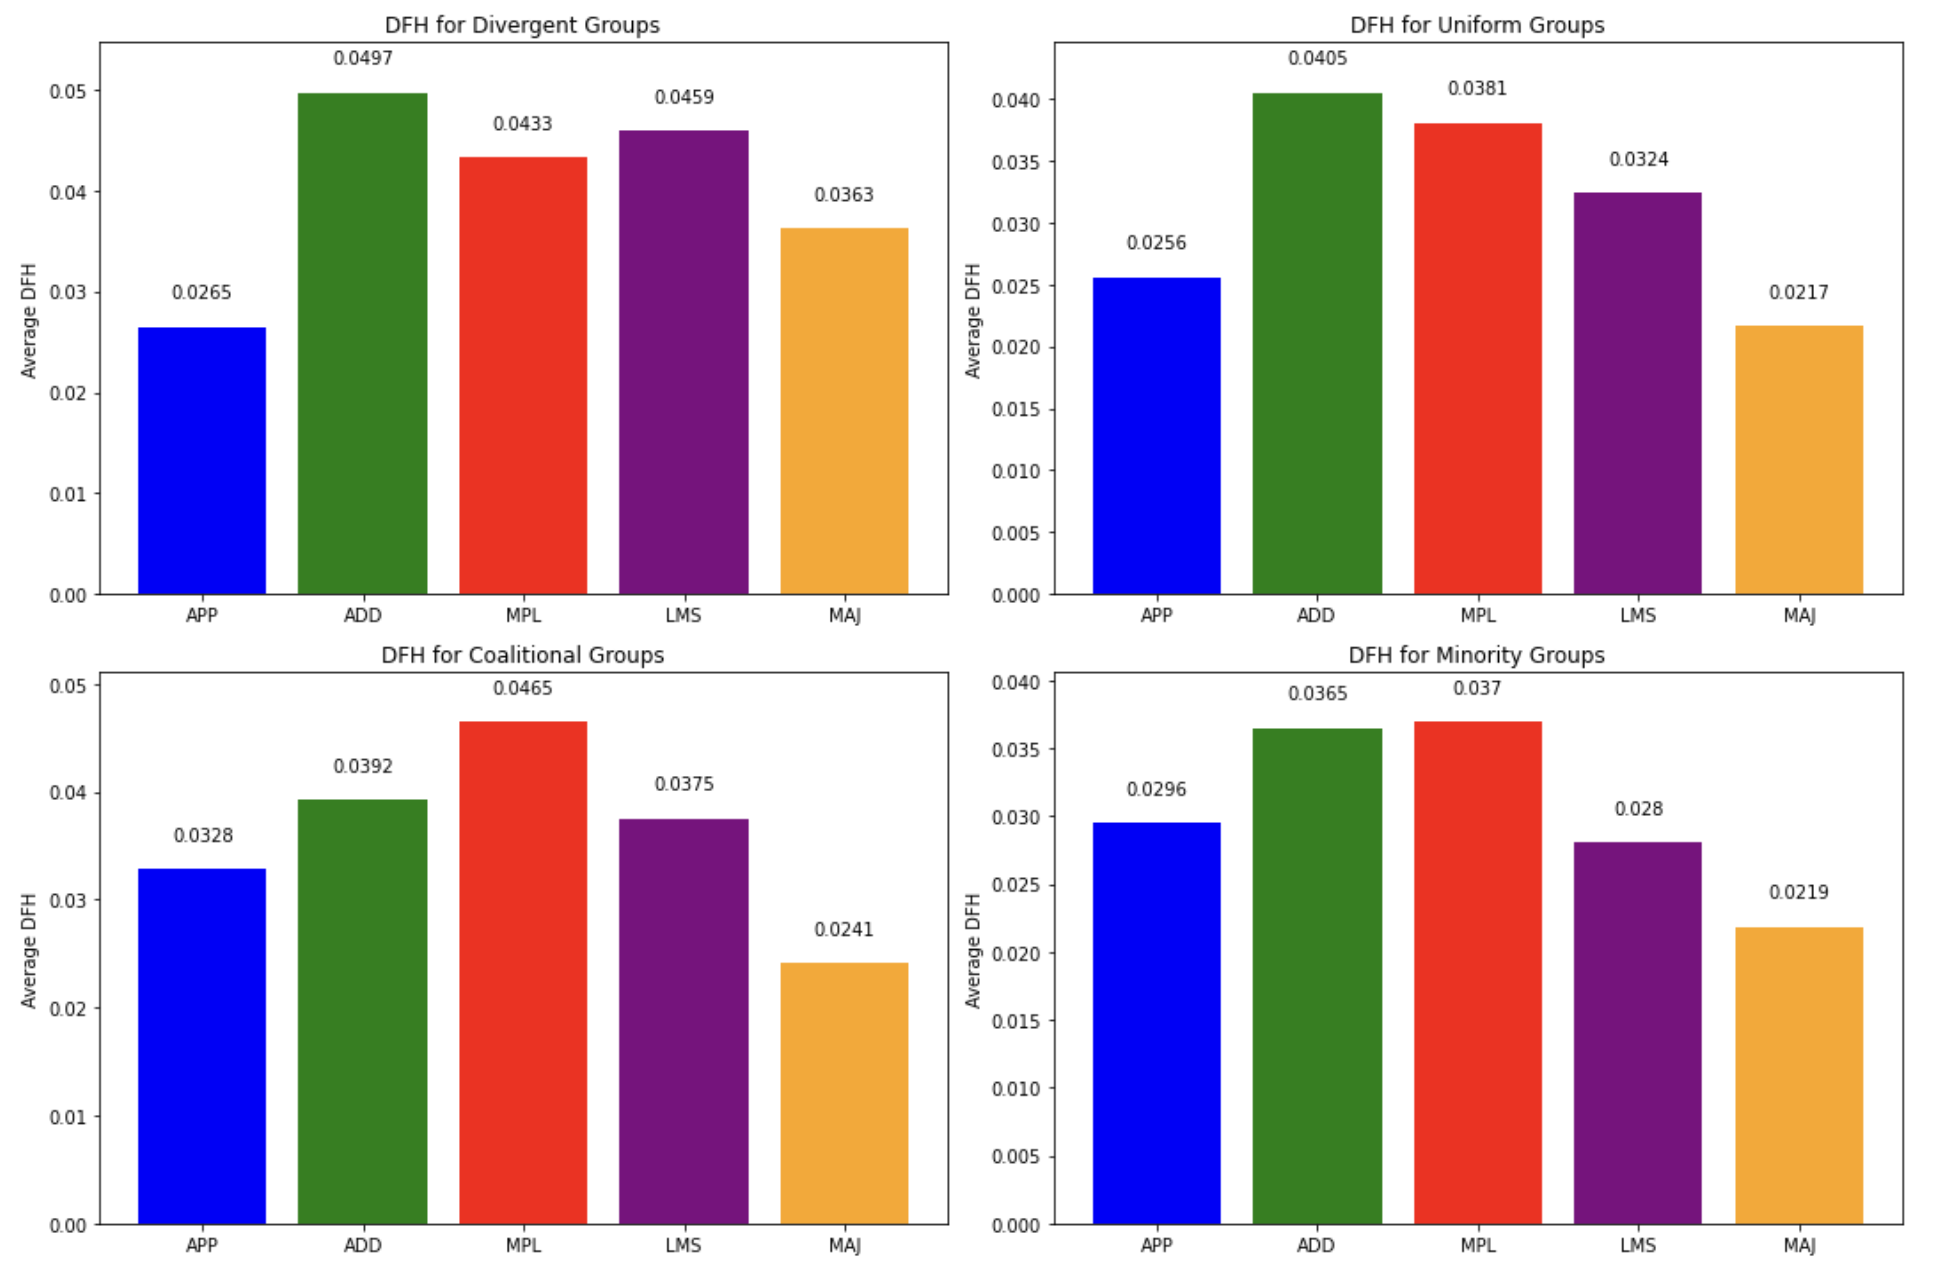

### Avoiding decoupled evaluation bias

- Implementing and evaluating several metrics for all group aggregations and compositions was the main action to mitigate DEB. 

## Explanations

Goal of the explanations is to provide additional information that is associated with the recommendations. This is done to achieve goals such as promoting consensus, increasing transparency, effectiveness, usability and user satisfaction among users. 

The explanations provided are done based on social choice aggregation. These explanations are focused on reassuring users about the quality and relevance of the recommended movies, and potentially help repair any mistrust or confusion about the system’s functionality or rationale. 

The explanations for each aggregation strategy are as follows:

- “We advise the group to consider movie x.”  -> This is the default for "no explanation". 


ADD 
- “Movie x has been recommended to the group because it holds the maximum cumulative rating.” - Basic explanation
- “Movie x has been recommended to the group because it holds the maximum cumulative rating. This means after adding 

all group members ratings’ for all movies, movie x had the highest sum.” - Detailed explanation

APP 
- “Movie x has been recommended to the group because it has the highest amount of ratings above threshold θ.”- Basic explanation
- “Movie x has been recommended to the group because it has the highest amount of ratings above threshold θ . This means after gathering all group members ratings for each movie, movie x had the most ratings above θ.” - Detailed explanation


LMS 
- “Movie x has been recommended to the group as it doesn't pose significant issues for any member.” - Basic explanation
- “Movie x has been recommended to the group as it doesn't pose significant issues for any member. This means that for all movies rated, the highest rating amongst all lowest ratings per movie was the lowest rating of movie x. “- Detailed explanation

MPL 
- “Movie x is recommended to the group as it has received the highest ratings from all members.” - Basic explanation
- “Movie x is recommended to the group as it has received the highest ratings from all members. This means that for the highest ratings from all group members for each movie, movie x had the highest rating.“ - Detailed explanation 

MAJ
- "Movie x is suggested for the group as it is favored by the majority of members." - Basic explanation
- "Movie X is suggested for the group as it is favored by the majority of members. This means the majority of the members in the group gave it a high rating." - Detailed explanation 


In [ ]:
def get_movie_title(movie_id):
    movie_row = movies_df[movies_df['item'] == movie_id]
    return movie_row.iloc[0]['title']


def generate_explanations(group, aggregation_strat, group_id, n_of_recommendations):

    if(aggregation_strat == "ADD"):
        group_results = additive_utilitarian_strategy(group ,n_of_recommendations)
        recommended_movies = ', '.join(map(lambda id_: f"'{get_movie_title(id_)}'", group_results.index))
        if(len(group_results)>1):
            print(f"No explanation: We advise group {int(group_id.split('_')[-1])} to consider movies {recommended_movies}.")
            print(f"Basic explanation: Movies {recommended_movies} have been recommended to group {int(group_id.split('_')[-1])} because they hold the maximum cumulative rating.")
            print(f"Detailed explanation: Movies {recommended_movies} have been recommended to group {int(group_id.split('_')[-1])} because they hold the maximum cumulative rating. This means after adding all group members ratings’ for all movies, movies {recommended_movies} have the highest sum.")
        else:
            print(f"No explanation: We advise group {int(group_id.split('_')[-1])} to consider movie {recommended_movies}.")
            print(f"Basic explanation: Movie {recommended_movies} has been recommended to group {int(group_id.split('_')[-1])} because it holds the maximum cumulative rating.")
            print(f"Detailed explanation: Movie {recommended_movies} has been recommended to group {int(group_id.split('_')[-1])} because it holds the maximum cumulative rating. This means after adding all group members ratings’ for all movies, movie {recommended_movies} had the highest sum.")
    if(aggregation_strat == "APP"):
        group_results = approval_voting_strategy(group, n_of_recommendations)
        recommended_movies = ', '.join(map(lambda id_: f"'{get_movie_title(id_)}'", group_results.index))
        if(len(group_results)>1):
            print(f"No explanation: We advise group {int(group_id.split('_')[-1])} to consider movies {recommended_movies}.")
            print(f"Basic explanation: Movies {recommended_movies} have been recommended to group {int(group_id.split('_')[-1])} because they have the highest amount of ratings above threshold θ.")
            print(f"Detailed explanation: Movies {recommended_movies} have been recommended to group {int(group_id.split('_')[-1])} because they have the highest amount of ratings above threshold θ . This means after gathering all group members ratings for each movie, movies {recommended_movies} have the most ratings above θ.")
        else:
            print(f"No explanation: We advise group {int(group_id.split('_')[-1])} to consider movie {recommended_movies}.")
            print(f"Basic explanation: Movie {recommended_movies} has been recommended to group {int(group_id.split('_')[-1])} because it has the highest amount of ratings above threshold θ.")
            print(f"Detailed explanation: Movie {recommended_movies} has been recommended to group {int(group_id.split('_')[-1])} because it has the highest amount of ratings above threshold θ . This means after gathering all group members ratings for each movie, movie {recommended_movies} had the most ratings above θ.")
    if(aggregation_strat == "LMS"):
        group_results = least_misery_strategy(group, n_of_recommendations)
        recommended_movies = ', '.join(map(lambda id_: f"'{get_movie_title(id_)}'", group_results.index))
        if(len(group_results)>1):
            print(f"No explanation: We advise group {int(group_id.split('_')[-1])} to consider movies {recommended_movies}.")
            print(f"Basic explanation: Movies {recommended_movies} have been recommended to group {int(group_id.split('_')[-1])}) as they don't pose significant issues for any member.")
            print(f"Detailed explanation: Movies {recommended_movies} have been recommended to group {int(group_id.split('_')[-1])}) as they don't pose significant issues for any member. This means that for all movies rated, the highest ratings amongst all lowest ratings per movie was the lowest rating of movies {recommended_movies}.")
        else:
            print(f"No explanation: We advise group {int(group_id.split('_')[-1])} to consider movie {recommended_movies}.")
            print(f"Basic explanation: Movie {recommended_movies} has been recommended to group {int(group_id.split('_')[-1])} as it doesn't pose significant issues for any member.")
            print(f"Detailed explanation: Movie {recommended_movies} has been recommended to group {int(group_id.split('_')[-1])} as it doesn't pose significant issues for any member. This means that for all movies rated, the highest rating amongst all lowest ratings per movie was the lowest rating of movie {recommended_movies}.")
    if(aggregation_strat == "MPL"):
        group_results = most_pleasure_strategy(group, n_of_recommendations)
        recommended_movies = ', '.join(map(lambda id_: f"'{get_movie_title(id_)}'", group_results.index))
        if(len(group_results)>1):
            print(f"No explanation: We advise group {int(group_id.split('_')[-1])} to consider movies {recommended_movies}.")
            print(f"Basic explanation: Movies {recommended_movies} are recommended to group {int(group_id.split('_')[-1])} as they have received the highest ratings from all members.")
            print(f"Detailed explanation: Movies {recommended_movies} are recommended to group {int(group_id.split('_')[-1])} as they have received the highest ratings from all members. This means that for the highest ratings from all group members for each movie, movies {recommended_movies} had the highest rating.")
        else:
            print(f"No explanation: We advise group {int(group_id.split('_')[-1])} to consider movie {recommended_movies}.")
            print(f"Basic explanation: Movie {recommended_movies} is recommended to group {int(group_id.split('_')[-1])} as it has received the highest ratings from all members.")
            print(f"Detailed explanation: Movie {recommended_movies} is recommended to group {int(group_id.split('_')[-1])} as it has received the highest ratings from all members. This means that for the highest ratings from all group members for each movie, movie {recommended_movies} had the highest rating.")
    if(aggregation_strat == "MAJ"):
        group_results = majority_strategy(group, n_of_recommendations)
        recommended_movies = ', '.join(map(lambda id_: f"'{get_movie_title(id_)}'", group_results.index))
        if(len(group_results)>1):
            print(f"No explanation: We advise group {int(group_id.split('_')[-1])} to consider movies {recommended_movies}.")
            print(f"Basic explanation: Movies {recommended_movies} are suggested for group {int(group_id.split('_')[-1])} as they are favored by the majority of members.")
            print(f"Detailed explanation: Movies {recommended_movies} are suggested for group {int(group_id.split('_')[-1])} as  they are favored by the majority of members. This means the majority of the members in the group gave them a high rating.")
        else:
            print(f"No explanation: We advise group {int(group_id.split('_')[-1])} to consider movie {recommended_movies}.")
            print(f"Basic explanation: Movie {recommended_movies} is suggested for group {int(group_id.split('_')[-1])} as it is favored by the majority of members.")
            print(f"Detailed explanation: Movie {recommended_movies} is suggested for group {int(group_id.split('_')[-1])} as it is favored by the majority of members. This means the majority of the members in the group gave it a high rating.")

Example of an explanation generation:

In [ ]:
groups = minority_groups(grouped, 3) 

for group_id, group in groups.items(): 
    generate_explanations(group, "MAJ", group_id, 2)
    print("_________________________")

No explanation: We advise group 1 to consider movie .
Basic explanation: Movie  is suggested for group 1 as it is favored by the majority of members.
Detailed explanation: Movie  is suggested for group 1 as it is favored by the majority of members. This means the majority of the members in the group gave it a high rating.
_________________________
No explanation: We advise group 2 to consider movie .
Basic explanation: Movie  is suggested for group 2 as it is favored by the majority of members.
Detailed explanation: Movie  is suggested for group 2 as it is favored by the majority of members. This means the majority of the members in the group gave it a high rating.
_________________________
No explanation: We advise group 3 to consider movie .
Basic explanation: Movie  is suggested for group 3 as it is favored by the majority of members.
Detailed explanation: Movie  is suggested for group 3 as it is favored by the majority of members. This means the majority of the members in the group

## Evaluation of Explanations

Last thing to fill in for GRS. 